# Build some toy models and how to sample them

## Roadmap

- Step through training loop, line by line
- Run small training run!

In [1]:
# use autoreload
%load_ext autoreload
%autoreload 2

import yaml
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

# import lightning trainer
import lightning as L
from lightning.pytorch.loggers import WandbLogger

# imports
from jepa.modules import SemiContrastiveLearning

## Explore Model Loading

In [2]:
with open("configs/3_testing.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
model = SemiContrastiveLearning(**config)

## Training Step

In [13]:
for batch in model.train_dataloader():
    x, mask, events_df = batch
    print(x.shape, mask.shape)

    context_mask, target_mask, inner_target_flag = model.sample_context(x, mask)
    print(context_mask.shape, target_mask.shape)

    break


torch.Size([1, 8, 2]) torch.Size([1, 8])
torch.Size([1, 8]) torch.Size([1, 8])


In [14]:
model.training_step(batch, 0)

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(0.0359, grad_fn=<MseLossBackward0>)

In [18]:
x, mask, *_ = batch
context_mask, target_mask, inner_target_flag = model.sample_context(x, mask)
x = x.permute(1, 0, 2)
target = model.embed_target(x, mask, target_mask)
context = model.encoder(x, context_mask, context_mask)
prediction = model.predictor(context)

loss = F.mse_loss(prediction, target)

In [19]:
x.shape, target_mask.shape

(torch.Size([8, 1, 2]), torch.Size([1, 8]))

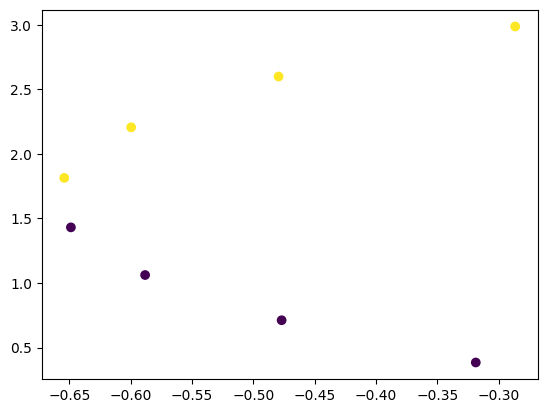

In [20]:
# Plot the x positions, along with whether they are in the context or target mask
plt.scatter(x[:, 0, 0], x[:, 0, 1], c=target_mask[0])
plt.show()

## Train Run

In [4]:
with open("configs/3_testing.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
model = SemiContrastiveLearning(**config)

In [6]:
wandb_logger = WandbLogger(project="JEPA_toytrack_splittracks_2")
trainer = L.Trainer(
    max_epochs=100, 
    devices=1, 
    accelerator="gpu", 
    limit_train_batches = config["train_batches"], 
    limit_val_batches = config["val_batches"],
    logger = wandb_logger
)
trainer.fit(model=model)

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/d/danieltm/.conda/envs/jepa/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type        | Params
--------------------------------------------
0 | encoder     | JEPAEncoder | 5.6 K 
1 | ema_encoder | JEPAEncoder | 5.6 K 
2 | predictor   | Identity    | 0     
--------------------------------------------
5.6 K     Trainable params
5.6 K     Non-trainable params
11.2 K    Total params
0.045     Total estimated model params size (MB)


/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 100. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 99: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s, v_num=tzjl]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s, v_num=tzjl]


## Visualize Source-Target Encodings

In [24]:
model = model.to("cpu")

In [25]:
# Loop through a 10 batches, append the source, target encodings
source_encodings = []
target_encodings = []

batches = 0

with torch.no_grad():
    for batch in model.train_dataloader():
        results = model.shared_evaluation(batch, 0)
        source_encodings.append(results["context"].detach())
        target_encodings.append(results["target"].detach())
        batches += 1
        if batches > 10:
            break


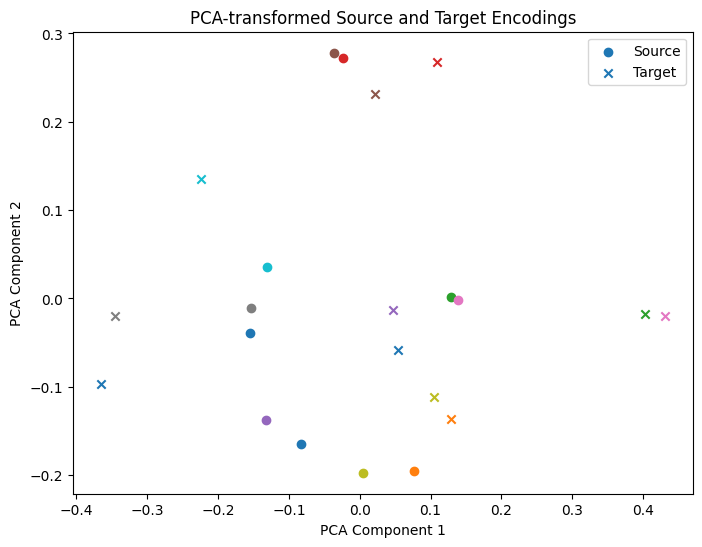

In [26]:
# Now PCA down the source and target encodings

# Sketch of changes:
# - Concatenate the source and target encodings into a single matrix
# - Perform PCA on the concatenated matrix to reduce dimensionality 
# - Extract the transformed source and target encodings from the PCA result
# - Visualize the PCA-transformed encodings in a scatter plot with matching colors for source and target encodings
# - Use 'o' for source encodings and 'x' for target encodings

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Concatenate source and target encodings
source_encodings_cat = np.concatenate([x.numpy() for x in source_encodings], axis=0)
target_encodings_cat = np.concatenate([x.numpy() for x in target_encodings], axis=0)
encodings_matrix = np.concatenate([source_encodings_cat, target_encodings_cat], axis=0)

# Perform PCA
pca = PCA(n_components=2)
pca_encodings = pca.fit_transform(encodings_matrix)

# Extract transformed source and target encodings
pca_source_encodings = pca_encodings[:len(source_encodings_cat)]
pca_target_encodings = pca_encodings[len(source_encodings_cat):]

# Visualize PCA-transformed encodings
plt.figure(figsize=(8, 6))
for i in range(len(pca_source_encodings)):
    plt.scatter(pca_source_encodings[i, 0], pca_source_encodings[i, 1], color=f'C{i}', marker='o', label='Source' if i == 0 else "")
    plt.scatter(pca_target_encodings[i, 0], pca_target_encodings[i, 1], color=f'C{i}', marker='x', label='Target' if i == 0 else "")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('PCA-transformed Source and Target Encodings')
plt.show()

In [27]:
# Loop through a 10 batches, append the source, target encodings
prediction_encodings = []
target_encodings = []

batches = 0

with torch.no_grad():
    for batch in model.train_dataloader():
        results = model.shared_evaluation(batch, 0)
        prediction_encodings.append(results["prediction"].detach())
        target_encodings.append(results["target"].detach())
        batches += 1
        if batches > 10:
            break


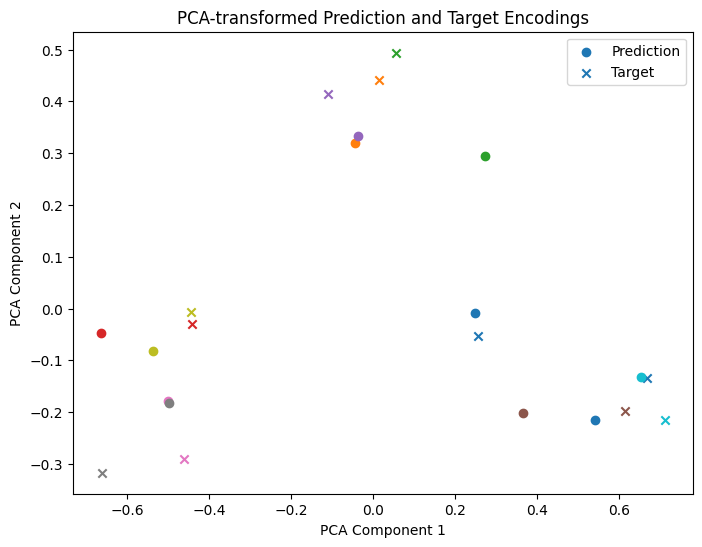

In [28]:
# Now PCA down the source and target encodings

# Sketch of changes:
# - Concatenate the source and target encodings into a single matrix
# - Perform PCA on the concatenated matrix to reduce dimensionality 
# - Extract the transformed source and target encodings from the PCA result
# - Visualize the PCA-transformed encodings in a scatter plot with matching colors for source and target encodings
# - Use 'o' for source encodings and 'x' for target encodings

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Concatenate source and target encodings
prediction_encodings_cat = np.concatenate([x.numpy() for x in prediction_encodings], axis=0)
target_encodings_cat = np.concatenate([x.numpy() for x in target_encodings], axis=0)
encodings_matrix = np.concatenate([prediction_encodings_cat, target_encodings_cat], axis=0)

# Perform PCA
pca = PCA(n_components=2)
pca_encodings = pca.fit_transform(encodings_matrix)

# Extract transformed source and target encodings
pca_prediction_encodings = pca_encodings[:len(prediction_encodings_cat)]
pca_target_encodings = pca_encodings[len(prediction_encodings_cat):]

# Visualize PCA-transformed encodings
plt.figure(figsize=(8, 6))
for i in range(len(pca_prediction_encodings)):
    plt.scatter(pca_prediction_encodings[i, 0], pca_prediction_encodings[i, 1], color=f'C{i}', marker='o', label='Prediction' if i == 0 else "")
    plt.scatter(pca_target_encodings[i, 0], pca_target_encodings[i, 1], color=f'C{i}', marker='x', label='Target' if i == 0 else "")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('PCA-transformed Prediction and Target Encodings')
plt.show()